In [1]:
# for the glory of God
from collections import Counter
from cantera import Solution
from cantera._cantera import ConstPressureReactor, ReactorNet
from matplotlib.pyplot import plot, show
import matplotlib.pyplot as plt
from numpy.ma import array, arange
import pandas as pd
import numpy as np


def main():
# Create Reactor Networks
    m, tpArray, rArray, rn = createReactorNetwork()

# now compile a list of all variables for which we will store data
    columnNames = [rArray[0].component_name(item) for item in range(rArray[0].n_vars)]
    columnNames = ['pressure'] + columnNames

# use the above list to create a DataFrame
    timeHistory = [pd.DataFrame(columns=columnNames)]*len(tpArray)    

# Create t vector
    milliseconds = 0.001;
    dt = 0.0005*milliseconds;
    tau_mix = 0.05*milliseconds;
    end_time = 120*milliseconds;
    t = arange(0, end_time, dt)

# Iterative Solution
    T_1 = [None]*len(t)
    for i in range(0,len(t)-1):
        
        rn.advance(t[i]);
        iem(m, tpArray, rArray, rn, dt, 1/tau_mix);

# Return values
    return t, T_1;

def iem(m, tpArray, rArray, rn, dt, omega):
    # Constant k:
    C_phi = 1;
    k = -C_phi * omega * 0.5 * dt;
    # Calculate average
    m_total_r = 1/sum(m)
    H = 0
    mX_total = Counter(tpArray[0].mass_fraction_dict().keys());
    for i in range(0,len(tpArray)):

        X = m[i]*tpArray[i].Y;

        H += tpArray[i].enthalpy_mass * m[i]
        mX_total += Counter(X)

    for keys in mX_total:
        mX_total[keys] *= m_total_r;

    H *= m_total_r;

    for i in range(0, len(tpArray)):
        h = tpArray[i].enthalpy_mass;
        h = h + (k * (h - H));
        Y = tpArray[i].mass_fraction_dict();

        for keys in Y:
            Y[keys] = Y[keys] + (k * (Y[keys] - mX_total[keys]))

        tpArray[i].HPY = [h, tpArray[i].P, Y]
        rArray[i].syncState();

    rn.reinitialize();

def createReactorNetwork():
    m = array([6, 2, 0.5]);
    s1 = Solution('h2o2.cti');
    s2 = Solution('h2o2.cti');
    s3 = Solution('h2o2.cti');

    s1.TPX = 200, 101325, 'H2:0.75, O2:0.25';
    s2.TPX = [300, 101325, 'O2:0.75, H2:0.25'];
    s3.TPX = [500, 101325, 'H2:1, O2:0.5'];
#     s3.equilibrate('HP');
    tpArray = array([s1, s2, s3])
    
    r1 = ConstPressureReactor(s1);
    r2 = ConstPressureReactor(s2);
    r3 = ConstPressureReactor(s3);
    rArray = array([r1, r2, r3])
    
    rn = ReactorNet([r1, r2, r3]);
    
    r1.syncState(); 
    r2.syncState(); 
    r3.syncState();
    rn.reinitialize()
    return m, tpArray, rArray, rn;


In [2]:
# Create Reactor Networks
m, tpArray, rArray, rn = createReactorNetwork()

# now compile a list of all variables for which we will store data
columnNames = ['T'] + ['P'] + ['Enthalpy'] + rArray[0].thermo.species_names
# columnNames = [stirredReactor.component_name(item) for item in range(stirredReactor.n_vars)]
# columnNames = ['pressure'] + columnNames

# use the above list to create a DataFrame
# timeHistory = [pd.DataFrame(columns=columnNames)]*len(tpArray)    
timeHistory = [pd.DataFrame(columns=columnNames) for i in range(len(tpArray))]

# print(timeHistory)
# Create t vector
milliseconds = 0.001;
dt = 0.0005*milliseconds;
tau_mix = 0.05*milliseconds;
omega = 1/tau_mix;
end_time = 1*milliseconds;
t = arange(0, end_time, dt)

#Iterative Solution
counter = 0; 
for i in range(0,len(t)):
    for j in range(0, len(tpArray)):
# We will store only every 10th value. 
        if(counter%10 == 0):
        #Extract the state of the reactor
            state = np.hstack([rArray[j].thermo.T, rArray[j].thermo.P, m[j]*rArray[j].thermo.enthalpy_mass, 
                               rArray[j].thermo.X])
        
    #Update the dataframe
            timeHistory[j].loc[t[i]] = state
    rn.advance(t[i]);
    iem(m, tpArray, rArray, rn, dt, omega);
    counter += 1
    
# %matplotlib inline
# plt.plot(timeHistory[0].index, timeHistory[0]['T'])
# plt.xlabel('Time (s)')
# plt.ylabel('Temperature (K)');
# plt.ylim(300, 3300);

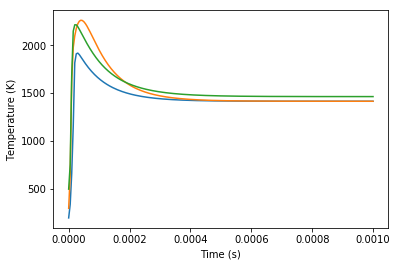

In [3]:
%matplotlib inline
plt.plot(timeHistory[0].index, timeHistory[0]['T'],
         timeHistory[1].index, timeHistory[1]['T'],
         timeHistory[2].index, timeHistory[2]['T']) 
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)');
# plt.ylim(300, 3300);
# plt.xlim(0, 0.1*milliseconds)

# tpArray[1].equilibrate('HP'); 
# tpArray[1].T

In [167]:
# %matplotlib inline 
timeHistory[0] 
# help(Solution.n_species)

,T,P,H,H2,H,O,O2,OH,H2O,HO2,H2O2,AR
0.000000,200.000000,101325.0,-1.765175e+06,0.750000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
0.000005,340.764328,101325.0,-1.731079e+06,0.737008,0.005746,0.000560,0.227520,0.001748,0.019557,0.001491,0.005279,0.001091
0.000010,661.716934,101325.0,-1.698650e+06,0.706039,0.013838,0.001035,0.201046,0.002813,0.067509,0.000780,0.004551,0.002389
0.000015,1154.851312,101325.0,-1.667806e+06,0.608403,0.055603,0.003794,0.149422,0.003084,0.175310,0.000388,0.000346,0.003651
0.000020,1815.581067,101325.0,-1.638470e+06,0.297724,0.217864,0.013166,0.008597,0.023639,0.433714,0.000183,0.000170,0.004942
0.000025,1910.240246,101325.0,-1.610568e+06,0.321801,0.199435,0.011072,0.006516,0.024100,0.430690,0.000179,0.000168,0.006040
0.000030,1917.211360,101325.0,-1.584031e+06,0.336538,0.194052,0.009587,0.005342,0.022401,0.424721,0.000175,0.000166,0.007017
0.000035,1901.162326,101325.0,-1.558791e+06,0.348365,0.191978,0.008420,0.004494,0.020423,0.418081,0.000172,0.000163,0.007903
0.000040,1878.488725,101325.0,-1.534785e+06,0.358916,0.190821,0.007447,0.003832,0.018535,0.411404,0.000169,0.000161,0.008714
0.000045,1854.401551,101325.0,-1.511952e+06,0.368728,0.189848,0.006619,0.003299,0.016823,0.404899,0.000166,0.000159,0.009460
